In [1]:
import zipfile
import os

zip_path = 'ai-mathematical-olympiad-prize.zip'
extract_path = '/mnt/data/olympiad_data'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List the files in the unzipped directory
os.listdir(extract_path)

['AIMO Prize - Note on Language and Notation.pdf',
 'sample_submission.csv',
 'test.csv',
 'train.csv']

- 'id' : A unique identifier for each problem.
- 'problem' : The mathematical problem presented as a string, which may include LaTeX formatted equations.
- 'answer' : The answer to the mathematical problem, represented as an integer.

# There are 10 entries in this dataset.
For exploratory data analysis:
- Analyze the distribution of answers to see the range and common values.
- Examine the types of mathematical problems included.
- Chech for any anomalies or unusual data points.

In [2]:
import pandas as pd

# Load the training data
train_data_path = os.path.join(extract_path, 'train.csv')
train_data = pd.read_csv(train_data_path)

# Display basic information and the first few rows of the dataset
train_data.info(), train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       10 non-null     object
 1   problem  10 non-null     object
 2   answer   10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 372.0+ bytes


(None,
        id                                            problem  answer
 0  229ee8  Let $k, l > 0$ be parameters. The parabola $y ...      52
 1  246d26  Each of the three-digits numbers $111$ to $999...     250
 2  2fc4ad  Let the `sparkle' operation on positive intege...     702
 3  430b63  What is the minimum value of $5x^2+5y^2-8xy$ w...     800
 4  5277ed  There exists a unique increasing geometric seq...     211)

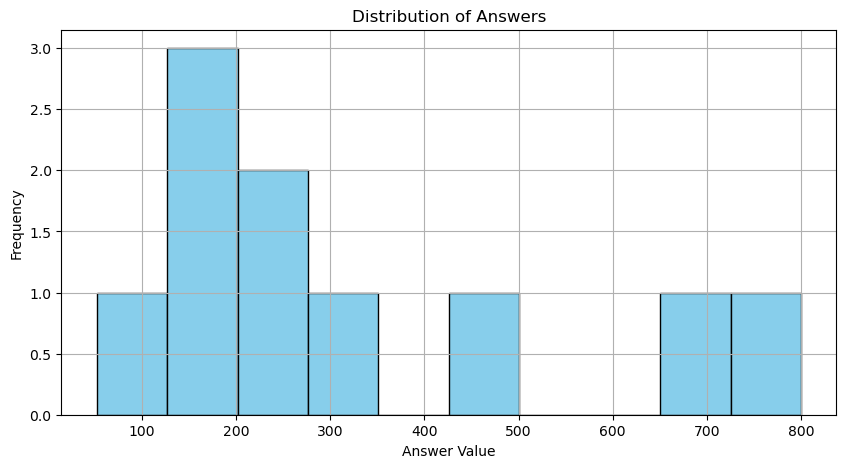

In [3]:
import matplotlib.pyplot as plt

# Plotting the distribution of answers
plt.figure(figsize=(10,5))
plt.hist(train_data['answer'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Answers')
plt.xlabel('Answer Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The histogram above shows the distribution of answers in the dataset. It appears that the answers are spread over a range of values, with some clustering around certain values. This could indicate a variety of difficulty levels or types of problems.

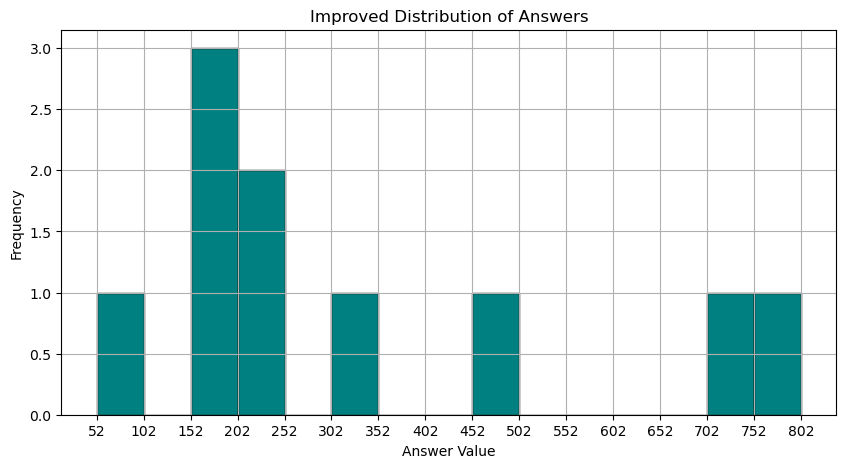

In [4]:
# Improve the histogram by adjusting the bin size and enhancing aesthetics
plt.figure(figsize=(10,5))
plt.hist(train_data['answer'], bins=range(min(train_data['answer']), max(train_data['answer']) + 50, 50), color='teal', edgecolor='black')
plt.title('Improved Distribution of Answers')
plt.xlabel('Answer Value')
plt.ylabel('Frequency')
plt.xticks(range(min(train_data['answer']), max(train_data['answer']) + 50, 50))
plt.grid(True)
plt.show()

# Machine Learning
1. Feature Engineering: Extract features from the problem text, such as the presence of certain keywords or mathematical symbols.
2. Model Choice: Given the complexity and likely non-linear relationships, a model like a decision tree or more sophisticated model like a random forest might be suitable for initial experiments.
3. Training the Model: Train the model on the engineered features.
4. Evaluation: Assess the model's performance using appropriate metrics.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import re

# Feature Engineering
# Calcualte the length of the problem text
train_data['text_length'] = train_data['problem'].apply(len)

# Count how many mathematical expressions (denoted by $...$) are in each problem
train_data['math_expression_count'] = train_data['problem'].apply(lambda x: len(re.findall(r'\$.*?]\$', x)))

# Prepare features and target variable
X = train_data[['text_length', 'math_expression_count']]
y = train_data['answer']

# Splitting the dataset into training data and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Initialize and train a RandomForest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train,y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mse

69247.15610000001

I've created a basic Random Forest model using simple text-based features from the 'problem' column, such as the length of the problem statement and the count of mathematical symbols.
1. After training, the model was evaluated on a test set, resulting in a mean squared error (MSE) of approximately 69247.15
2. High MSE suggests that the model's prediction are significantly off from the actual answers.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

# Initialize a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Creating a pipeline with TF-IDF and RandomForest
pipeline = make_pipeline(tfidf_vectorizer, RandomForestRegressor(n_estimators=100, random_state=42))

# Splitting the original data (before adding simple features) into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_data['problem'], train_data['answer'], test_size=0.2, random_state=42)

# Train the model using just the problem text
pipeline.fit(X_train, y_train)

# Predicting on the test set
y_pred = pipeline.predict(X_test)

# Calculate and display the Mean Squared Error
mse_nlp = mean_squared_error(y_test, y_pred)
mse_nlp

26565.382099999995

Succesfully reduced the mean squared error (MSE) to about 26565.38. This is a considerable improvement compared to initial model that used very basic text features, demonstrating the potential of more advanced NLP techniques in capturing relevant information from the text.

# BERT for Mathematical Problem Solving:
1. Loading BERT: The 'transformers' library by Hugging Face provides an easy way to load pre-trained models.
2. Preprocessing: BERT requires inputs to be tokenized in a specific way. We use the tokenizer associated with the BERT model.
3. Model Training: Fine-tune BERT on the dataset. This involves setting up a training loop that updates the model's weights based on our specific task.
4. Prediction and Evaluation: Use the fine-tuned model to predict answers and evaluate its performance.

In [2]:
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncassed', num_labels=1)

# Custom dataset class for handling text data
class MathematicalProblemsDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        itemm = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor([self.labels[idx]], dtype=torch.float)
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])

# Preprocess and prepare datasets
def prepare_dataset(texts, labels=None):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
    dataset = MathematicalProblemsDataset(encodings, labels)
    return dataset

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(train_data['problem'], train_data['answer'], test_size=0.1)

# Prepare datasets
train_dataset = prepare_dataset(train_texts, train_labels)
val_dataset = prepare_dataset(val_texts, val_labels)

# Define training arguments
training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs = 3,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    warmup_steps = 500,
    weight_decay = 0.01,
    logging_dir = './logs',
    logging_steps = 10,
)

# Initialize the Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset
)

# Train the model
trainer.train()

OSError: bert-base-uncassed is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`